In [1]:
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import datasets, transforms as T

In [44]:
# Define the hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 10 # In percentage

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

In [45]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [46]:
# Set seed during training for reproducibility
# torch.manual_seed(0)
# if use_cuda:
#     torch.cuda.manual_seed(0)

In [47]:
# Normalise the dataset
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
            ])
# Augement and normalise the dataset
transform_aug = T.Compose([
                  T.RandomCrop(32, padding=4),
                  T.RandomHorizontalFlip(p=0.5),
                  T.ToTensor(),
                  T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
                ])

In [48]:
training_dataset = datasets.CIFAR10(root='data/', train=True,  transform=transform, download=True)
testing_dataset  = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)

split_point = math.floor( (100-VAL_SIZE) * len(training_dataset) / 100) 
indices = list(range(len(training_dataset)))

training_dataloader   = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.SubsetRandomSampler(indices[:split_point],))
                                                                                                #  generator = torch.Generator().manual_seed(0)))
validation_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.SubsetRandomSampler(indices[split_point:],))
                                                                                                #  generator = torch.Generator().manual_seed(0)))
testing_dataloader    = torch.utils.data.DataLoader(testing_dataset,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvLayer,self).__init__()
        self.conv_layer = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
                          )

    def forward(self, x):
        return self.conv_layer(x)

class InceptionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionLayer,self).__init__()
        self.layer_1_conv = ConvLayer(in_channels=in_channels, out_channels=out_channels[0], kernel_size=1, stride=1, padding=0)
        
        self.layer_3_conv = nn.Sequential(
                                ConvLayer(in_channels=in_channels,    out_channels=in_channels//2,  kernel_size=1, stride=1, padding=0),
                                ConvLayer(in_channels=in_channels//2, out_channels=out_channels[1], kernel_size=3, stride=1, padding=1),
                            )
        
        self.layer_5_conv = nn.Sequential(
                                ConvLayer(in_channels=in_channels,     out_channels=in_channels//12, kernel_size=1, stride=1, padding=0),
                                ConvLayer(in_channels=in_channels//12, out_channels=out_channels[2], kernel_size=5, stride=1, padding=2),
                            )
        
        self.layer_pooling = nn.Sequential(
                                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                ConvLayer(in_channels=in_channels, out_channels=out_channels[3], kernel_size=1, stride=1, padding=0)
                            )
    
    def forward(self, x):
        return torch.cat((self.layer_1_conv(x),self.layer_3_conv(x),self.layer_5_conv(x),self.layer_pooling(x)), dim=1)

In [50]:
# Note: Maximum pooling is used, unlike the original architecture where average pooling is used
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel,self).__init__()
        self.lenet = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=64,  kernel_size=3, stride=1, padding=0),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2),
            
                        nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, stride=1, padding=0),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
            
                        InceptionLayer(in_channels=128,          out_channels=[64,128,32,32]),
            
                        nn.MaxPool2d(kernel_size=2,stride=2),
            
                        InceptionLayer(in_channels=64+128+32+32, out_channels=[128,256,64,64]),
            
                        nn.AvgPool2d(kernel_size=5,stride=2),
                        nn.Dropout(p=0.5),
            
                        nn.Flatten(),
                        nn.Linear(in_features=512,  out_features=10)
                     )
    def forward(self,x):
        return self.lenet(x)

In [51]:
def loss_function(pred, y):
    return F.cross_entropy(pred, y)

In [52]:
validation_losses = []
def validate(model):
    losses = []
    
    model.eval()
    
    with torch.no_grad():
        for x_valid,y_valid in validation_dataloader:
            x_valid = x_valid.to(device=device, dtype=torch.float32)
            y_valid = y_valid.to(device=device, dtype=torch.long)
            
            pred = model(x_valid)
            
            loss = loss_function(pred,y_valid).item()
            losses.append(loss)
            
    validation_losses.append(statistics.mean(losses))

In [53]:
training_losses = []
def training(model, optimiser):
    for epoch in range(EPOCHS):
        losses = []
        model.train()
        
        for x_train, y_train in training_dataloader:
            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)
            
            pred = model(x_train)
            
            loss = loss_function(pred,y_train)
            losses.append(loss.item())
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
        mean_loss = statistics.mean(losses)
        training_losses.append(mean_loss)
        print("Epoch {}/{}, training loss = {:.2f}".format(epoch+1, EPOCHS, mean_loss))
        
        validate(model)

Epoch 1/10, training loss = 1.23
Epoch 2/10, training loss = 0.86
Epoch 3/10, training loss = 0.70
Epoch 4/10, training loss = 0.60
Epoch 5/10, training loss = 0.53
Epoch 6/10, training loss = 0.47
Epoch 7/10, training loss = 0.41
Epoch 8/10, training loss = 0.37
Epoch 9/10, training loss = 0.33
Epoch 10/10, training loss = 0.29


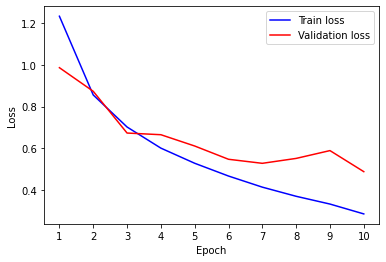

In [54]:
inceptionNetwork = InceptionModel()
inceptionNetwork = inceptionNetwork.to(device=device)

optimizer = optim.Adam(inceptionNetwork.parameters(), lr=LEARNING_RATE)

training(inceptionNetwork, optimizer)

plt.figure(0)
plt.plot(list(range(1,EPOCHS+1)), training_losses, 'b')
plt.plot(list(range(1,EPOCHS+1)), validation_losses, 'r')
plt.xticks(list(range(1,EPOCHS+1)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()

In [55]:
def testing(model):
    model.eval()
    
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for x_test, y_test in testing_dataloader:
            x_test = x_test.to(device=device, dtype=torch.float32)
            y_test = y_test.to(device=device, dtype=torch.long)
            
            _,pred = model(x_test).max(1)
            
            correct_preds += (pred==y_test).sum()
            total_preds   += pred.size(0)
            
    accuracy = 100 * torch.true_divide(correct_preds,total_preds)
    print('Correct predictions {}/{}, accuracy = {:.2f}%.'.format(correct_preds, total_preds, accuracy))
    
testing(inceptionNetwork)

Correct predictions 8282/10000, accuracy = 82.82%.


In [ ]:
# Save weights if desired
# torch.save(inceptionNetwork.state_dict(), 'inceptionModel.pt')